In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from hyperparameters import *

In [2]:
def display_img(img, cmap="gray"):
    plt.imshow(img, cmap=cmap)
    plt.show()

In [3]:
def plot_histogram(image):
    # Calculate the histogram
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Plot the histogram
    plt.plot(histogram, color='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of the Image')
    plt.show()

In [4]:
import os

dir = "../Data set\CSE483 F23 Project Test Cases"
files = os.listdir(dir)

for file in files:
    print(file)

01-Normal.jpg
02-TheMightyFinger.jpg
03-WhereBorder.jpg
04-CompressoEspresso.jpg
05-Ya3amSheel2elCoinYa3am.jpg
06-FarAndCurved.jpg
07-2elNoor2ata3.jpg
08-MeshShayef7agaYa3am.jpg
09-Normal2.jpg
10-Mal7wFelfel.jpg
11-FlashBang.jpg
12-BrokenPrinter.jpg
13-DarkMode.jpg
14-Sine.jpg
15-GoneWithTheWind.jpg
16-SomethingWentTerriblyWrongHere.jpg


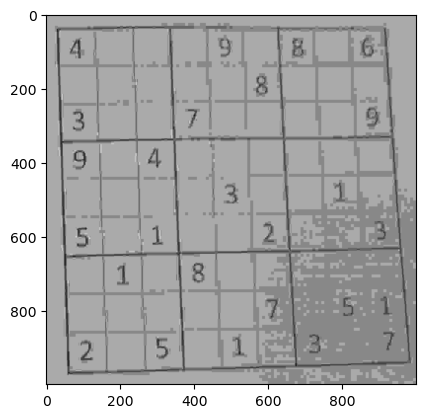

In [7]:
test = 8
original_img = cv2.imread(os.path.join(dir, files[test - 1]), cv2.IMREAD_UNCHANGED)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
display_img(original_img)

In [8]:
if np.median(original_img) < 94 and original_img.std() > 48:
    original_img = cv2.bitwise_not(original_img)
    display_img(original_img)

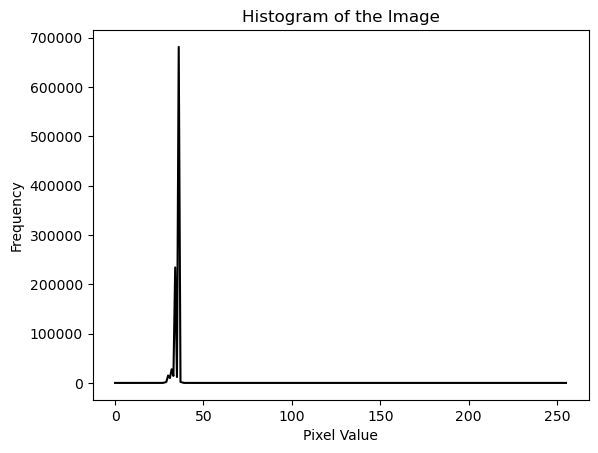

In [9]:
plot_histogram(original_img)

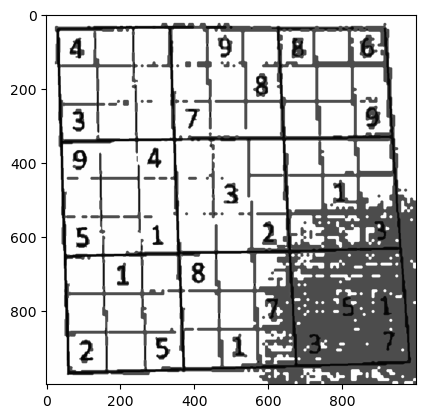

In [10]:
equalized_img = cv2.equalizeHist(original_img)
equalized_img = cv2.medianBlur(equalized_img, 5)
display_img(equalized_img)

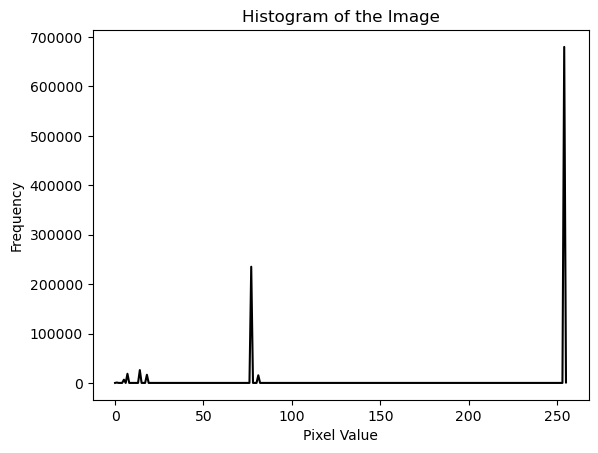

In [11]:
plot_histogram(equalized_img)

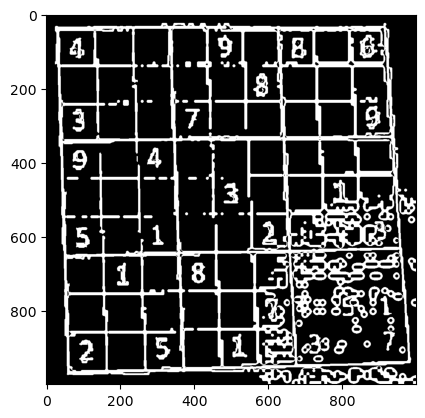

In [55]:
binary_img = cv2.adaptiveThreshold(
    src=equalized_img,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=adaptive_threshold_block_size,
    C=adaptive_threshold_c
)
display_img(binary_img)

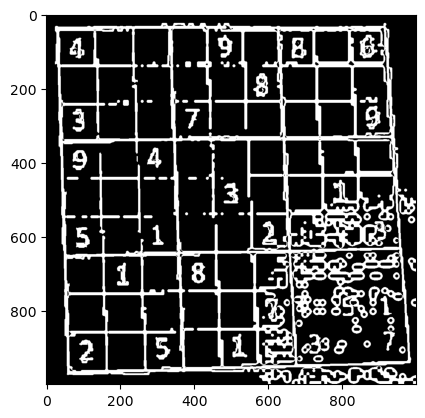

In [56]:
opening_kernel = np.ones((35, 35), np.uint8)
eroded_img = cv2.morphologyEx(
    binary_img, cv2.MORPH_OPEN, opening_kernel)
binary_img = binary_img - eroded_img
display_img(binary_img)

In [57]:
morph_struct = np.ones((5, 5), np.uint8)

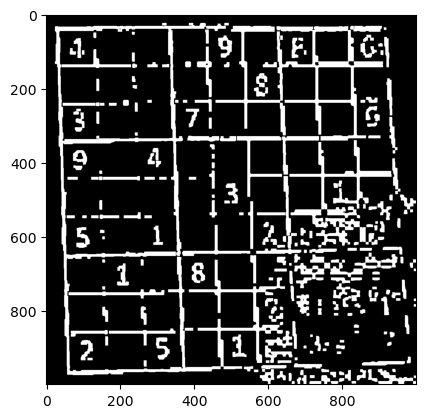

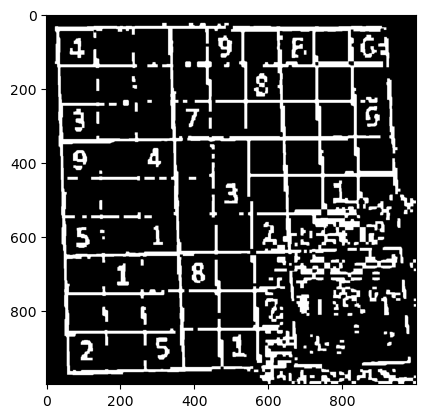

In [58]:
close_struct = np.ones((7, 7), np.uint8)
open_struct = np.ones((7, 7), np.uint8)
opened_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, open_struct, iterations=1)
display_img(opened_img)
closed_img = cv2.morphologyEx(opened_img, cv2.MORPH_CLOSE, close_struct, iterations=1)
display_img(closed_img)

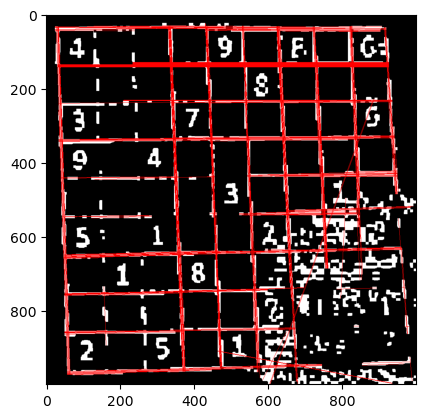

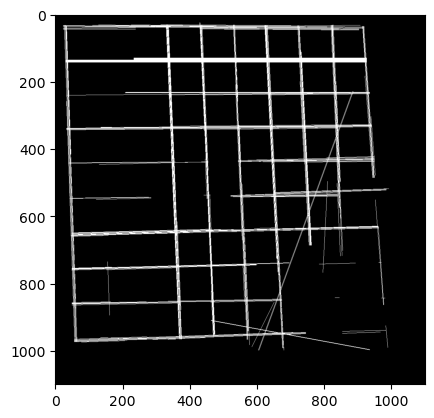

In [68]:
minLineLength = max(original_img.shape[0]/hough_min_line_length_ratio,original_img.shape[1])/hough_min_line_length_ratio

lines = cv2.HoughLinesP(
    closed_img,
    rho=hough_rho,
    theta=hough_theta,
    threshold=hough_threshold,
    minLineLength=2.5,
    maxLineGap=hough_max_line_gap
)

lines = lines.astype(np.int64)

binary_copy = cv2.cvtColor(closed_img, cv2.COLOR_GRAY2BGR)
lines_image = np.zeros_like(binary_img)
lines_image = cv2.copyMakeBorder(lines_image, test_image_padding, test_image_padding, test_image_padding, test_image_padding, cv2.BORDER_CONSTANT, value=(0,0,0))

for x1, y1, x2, y2 in lines[:,0]: cv2.line(lines_image,(x1,y1),(x2,y2),(255,0,0),1)
for x1, y1, x2, y2 in lines[:,0]: cv2.line(binary_copy,(x1,y1),(x2,y2),(255,0,0),1)

display_img(binary_copy)
display_img(lines_image)

In [69]:
def angle_between_lines(line1, line2):
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    a1 = np.rad2deg(np.arctan2(l1y2 - l1y1, l1x2 - l1x1))
    a2 = np.rad2deg(np.arctan2(l2y2 - l2y1, l2x2 - l2x1))
    return np.abs(a1 - a2)

def intersection_point(line1, line2):
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    nx = (l1x1*l1y2-l1y1*l1x2)*(l2x1-l2x2)-(l2x1*l2y2-l2y1*l2x2)*(l1x1-l1x2)
    ny = (l1x1*l1y2-l1y1*l1x2)*(l2y1-l2y2)-(l2x1*l2y2-l2y1*l2x2)*(l1y1-l1y2)
    d = (l1x1-l1x2)*(l2y1-l2y2)-(l1y1-l1y2)*(l2x1-l2x2)
    px = int(nx / d)
    py = int(ny / d)
    return (px, py)

def point_on_line(point, line):
    def distance(pfrom, pto): return np.sqrt((pfrom[0] - pto[0])**2 + (pfrom[1] - pto[1])**2)
    to_p1 = distance(point, line[0:2])
    to_p2 = distance(point, line[2:4])
    p1_p2 = distance(line[0:2], line[2:4])
    diff = to_p1 + to_p2 - p1_p2
    return np.abs(diff) < 500 # sus, this number should be close to zero, probably to allow broken lines


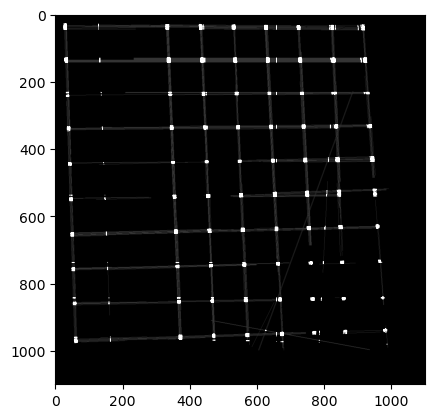

In [70]:
intersections_image = np.zeros_like(original_img, dtype=np.uint16)
intersections_image = cv2.copyMakeBorder(intersections_image, test_image_padding, test_image_padding, test_image_padding, test_image_padding, cv2.BORDER_CONSTANT, value=(0,0,0))

img_height = len(original_img)
img_width = len(original_img[0])

intersections = []
num_of_lines = len(lines[:,0])
# loop over each pair of lines
for i in range(num_of_lines):
    for j in range(i+1, num_of_lines):
        line1 = lines[i,0]
        line2 = lines[j,0]
        if (line1 is line2): continue
        a = angle_between_lines(line1, line2)
        # find the intersections between lines that are perpendicular on each other
        if (a < 80 or a > 100): continue
        p = intersection_point(line1, line2)
        if (point_on_line(p, line1) or point_on_line(p, line2)):
            # don't know why msha2lebhom but i assume that is the difference between the opencv and numpy
            intersections_image[p[::-1]] = 5000
            intersections.append(p[::-1])
        
plt.imshow(intersections_image + lines_image, cmap="gray", vmin=0, vmax=1255)
plt.show()

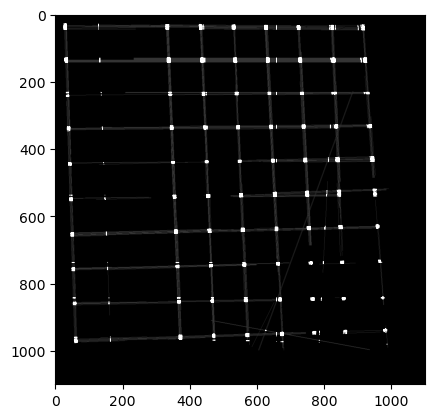

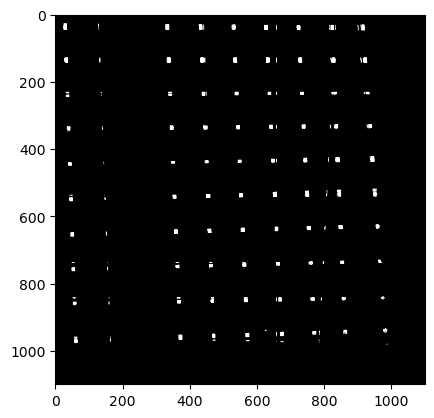

In [71]:
plt.imshow(intersections_image + lines_image, cmap="gray", vmin=0, vmax=1255)
plt.show()
plt.imshow(intersections_image, cmap="gray", vmin=0, vmax=1255)
plt.show()

##### extract squares

In [72]:
def euclidean_distance(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

In [73]:
#keep only 1 point from close points
intersection_distance_threshold = 50

print(len(intersections))

intersections = list(set(intersections))
filtered_points = set()
to_be_removed = set()

for i in range(len(intersections)):
    p1 = intersections[i]
    if p1 in to_be_removed:
        continue
    for j in range(i+1, len(intersections)):
        p2 = intersections[j]
        if p2 in to_be_removed:
            continue
        if euclidean_distance(p1, p2) < intersection_distance_threshold:
            to_be_removed.add(p2)
    
    
intersections = list(set(intersections).difference(to_be_removed))
print(len(intersections))


8028
91


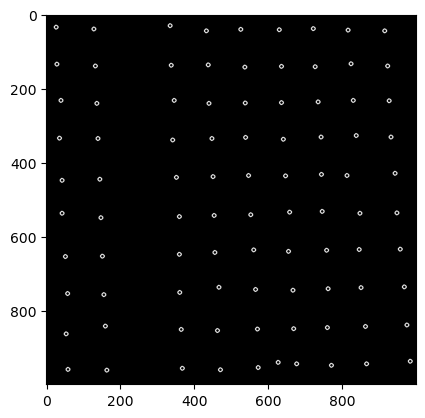

In [74]:
filtered_img = np.zeros_like(original_img)

for p in intersections:
    cv2.circle(filtered_img, (p[1], p[0]), 5, (255, 0, 0), 2)

display_img(filtered_img)

##### extract corners

[[[ 27  35]
  [915  45]
  [984 938]
  [ 59 960]]]


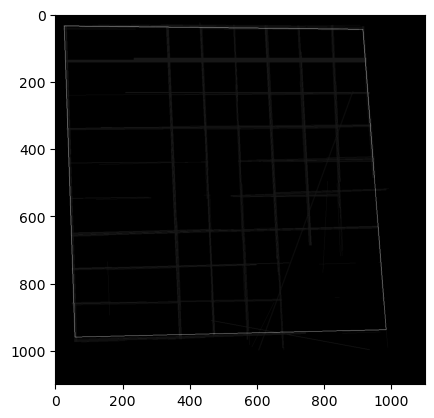

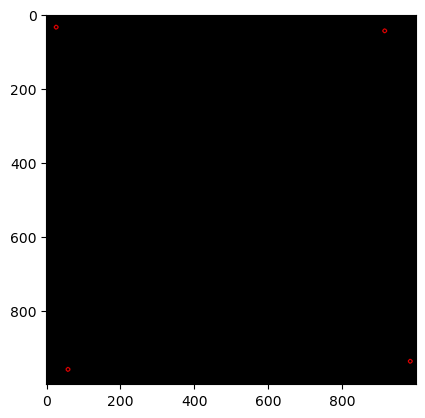

In [75]:
p1 = sorted(intersections, key = lambda p: p[0] + p[1])[0] # topleft
p2 = sorted(intersections, key = lambda p: p[0] - p[1])[0] # topright
p3 = sorted(intersections, key = lambda p: p[0] + p[1])[-1] # bottright
p4 = sorted(intersections, key = lambda p: p[1] - p[0])[0] # bottleft



# print(p1, p2, p3, p4)
# p1, p2, p3, p4 = find_largest_square(intersections, 70)
# print(p1, p2, p3, p4)

coords = np.int32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])

print(coords)

corner_points_image = np.zeros_like(binary_copy)
for coord in coords[0] : cv2.circle(corner_points_image, (coord[0], coord[1]), 5, (255, 0, 0), 2)

border_image = np.zeros_like(original_img, dtype = np.int32)
border_image = cv2.copyMakeBorder(border_image, test_image_padding, test_image_padding, test_image_padding, test_image_padding, cv2.BORDER_CONSTANT, value=(0,0,0))
border_image = cv2.polylines(border_image, coords, isClosed=True, color=(2550, 0, 0))

display_img(border_image + lines_image)
display_img(corner_points_image)


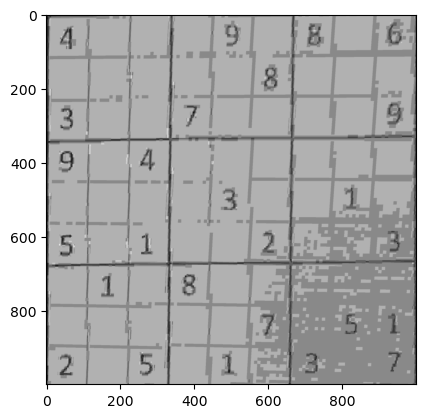

In [76]:
y, x = binary_img.shape
src_coords = np.float32([[0,0], [x,0], [x,y], [0,y]])
dst_coords = np.float32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
img_gray_threshed_warped = cv2.warpPerspective(
    src=original_img,
    M=cv2.getPerspectiveTransform(dst_coords, src_coords),
    dsize=binary_img.shape[::-1]
)
plt.imshow(img_gray_threshed_warped, cmap="gray")
plt.show()

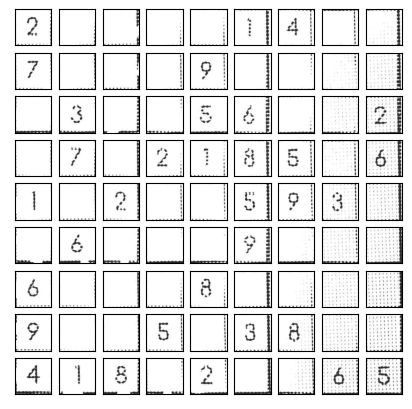

In [93]:
M = img_gray_threshed_warped.shape[0] // 9
N = img_gray_threshed_warped.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = img_gray_threshed_warped[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(number_tiles[i][j], cmap="gray")
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)

## Attempt using canny

In [35]:
# Canny hyperparameters
canny_threshold1 = 50
canny_threshold2 = 250
aperture_size = 3

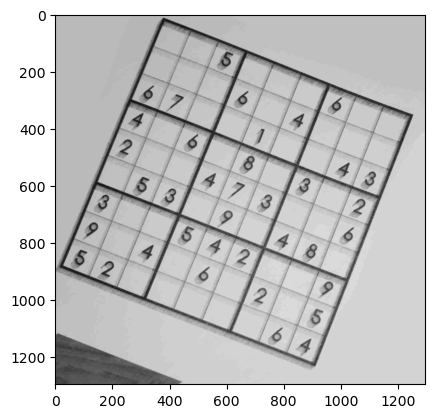

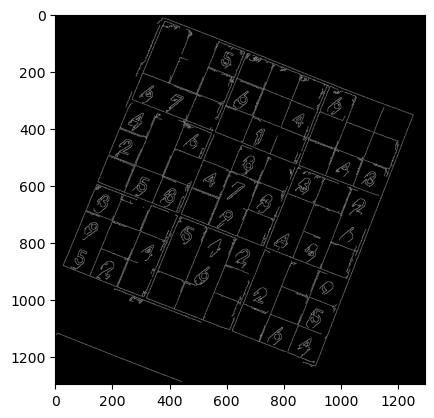

In [36]:
canny_image = cv2.Canny(original_img, canny_threshold1, canny_threshold2, apertureSize=aperture_size)
display_img(original_img)
display_img(canny_image)

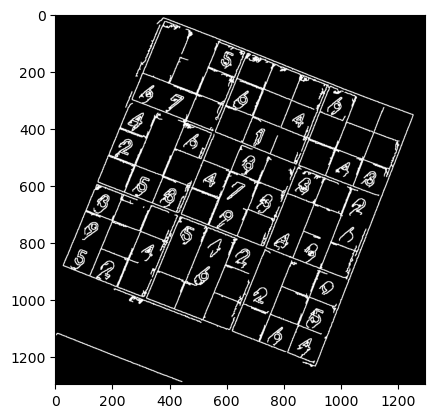

In [37]:
closing_kernel = np.matrix("1 1 1; 1 1 1; 1 1 1", np.uint8)
canny_closed = cv2.dilate(canny_image, closing_kernel)
display_img(canny_closed)

In [38]:
# Hough hyperparameters
hough_threshold = 200

In [39]:
lines = cv2.HoughLines(canny_closed, 1, np.pi/30, hough_threshold)

lines found: 496


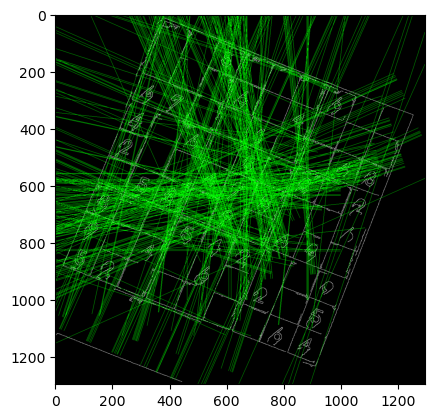

In [40]:
canny_copy = cv2.cvtColor(canny_image.copy(), cv2.COLOR_GRAY2BGR)
for r_theta in lines:
    arr = np.array(r_theta[0], dtype=np.float64)
    r, theta = arr
    
    if not ((0 <= theta < 0.5) or (((np.pi/2) - 0.5 < theta < (np.pi/2) + 0.5)) or (np.pi - 0.5 < theta <= np.pi)):
        continue
    
    a = np.cos(theta)
    b = np.sin(theta)

    x0 = a*r
    y0 = b*r
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(canny_copy, (x1, y1), (x2, y2), (0, 255, 0), 1)

print(f"lines found: {len(lines)}")
display_img(canny_copy)

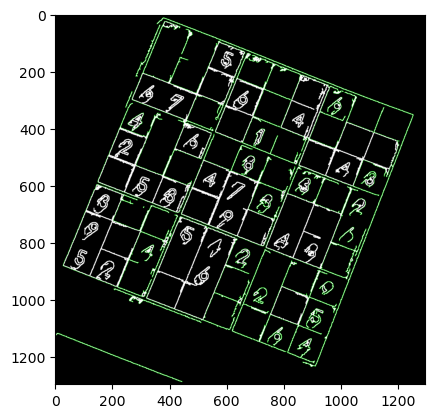

In [41]:
canny_copy = canny_closed.copy()
contours, hierarchy = cv2.findContours(canny_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
canny_copy = cv2.cvtColor(canny_copy, cv2.COLOR_GRAY2BGR)
cv2.drawContours(canny_copy, contours, -1, (0, 255, 0), 1)
display_img(canny_copy, None)

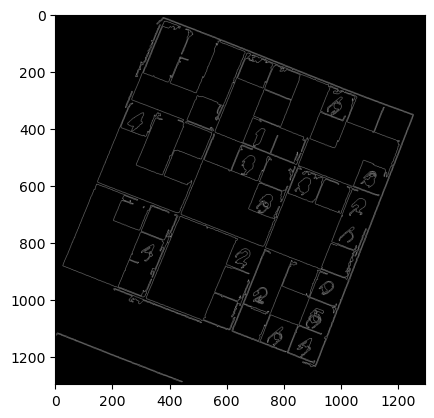

In [42]:
contours_image = np.zeros_like(original_img)
cv2.drawContours(contours_image, contours, -1, (255, 0, 0), 1)
display_img(contours_image)